# Computational Social Sciences - UDD

## Null models

This notebook was prepared by **Yessica Herrera-Guzmán** for the Computational Social Sciences course at Universidad del Desarrollo, which is taught by Cristian Candia-Vallejos.

Notebook based on the methods for: Herrera-Guzmán, Y., Lee, E. & Kim, H. Structural gender imbalances in ballet collaboration networks. EPJ Data Sci. 12, 53 (2023). https://doi.org/10.1140/epjds/s13688-023-00428-z

Full data can be found here: https://doi.org/10.5281/zenodo.8374171

**Introduction**

In network science, null models are useful to create a statistical baseline of randomly created networks, which would allow to test the absence or existence of randomness in structural patterns with respect to the observed empirical network. That is to say, if the observed features are statistically significant or if they could occur by chance.

The null model generates multiple randomized networks that preserve specific characteristics (e.g. degree centrality) of the empirical network, and introduces randomness in other network aspects. 

Then, the null hypothesis ($H_0$) can be tested to compare the statistical properties of the empirical and randomized networks. 

For instance:

\begin{equation}
H_0: \mu_1 = \mu_2
\end{equation}

where $\mu_1$ represents the mean of centrality values from the empirical networks, and $\mu_2$ is the mean of centrality values from the randomized networks. This null hypothesis assumes that any observed variations in network properties are within the range of what could occur by random chance alone.

**Methodology**

The selection of the null model depends on the null hypotheses to be tested, which should align with the theoretical foundations of the studied networks. Therefore, the null model must represent the key structural aspects of the network  being tested. 

In this notebook, we explore collaboration networks of ballet creators, which are assumed to be driven by homophilic preferences by gender. Thus, we propose two models to remove the collaborator -or gender- preferences by shuffling collaborations (edges) or artists' attributes (gender) in the network.

The data comprises professional ballet collaborations of artists at the American Ballet Theater, structured from their repertory archive available here: https://www.abt.org/explore/learn/repertory-archive/ballets/

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import csv

In [2]:
with open('ABT_nodelist.csv', 'r', encoding = 'utf-8') as nodecsv: # Open the file                       
    nodereader = csv.reader(nodecsv) # Read the csv  
    # Retrieve the data (using Python list comprhension and list slicing to remove the header row, see footnote 3)
    nodes = [n for n in nodereader][1:] 

In [3]:
node_names = [n[0] for n in nodes] 

In [4]:
# create empty graph
g = nx.Graph()

In [5]:
g.add_nodes_from(node_names)

In [6]:
gender_dict = {}
for node in nodes: 
    gender_dict[node[0]] = node[1]

In [7]:
nx.set_node_attributes(g, gender_dict, 'gender')

In [8]:
with open('ABT_edgelist.csv', 'r', encoding = 'utf-8') as edgecsv: # Open the file
    edgereader = csv.reader(edgecsv) # Read the csv     
    edges = [tuple(e) for e in edgereader][1:]

In [9]:
g.add_edges_from(edges)

In [10]:
g.remove_edges_from(nx.selfloop_edges(g))

In [11]:
# Verify that the network has been appropriately created
print(nx.info(g))

Graph with 779 nodes and 2323 edges


In [12]:
print(g.nodes['George Balanchine'])

{'gender': 'male'}


Check the network structure:

In [13]:
# Try a simple layout
pos = nx.spring_layout(g, k=0.1, iterations=50)

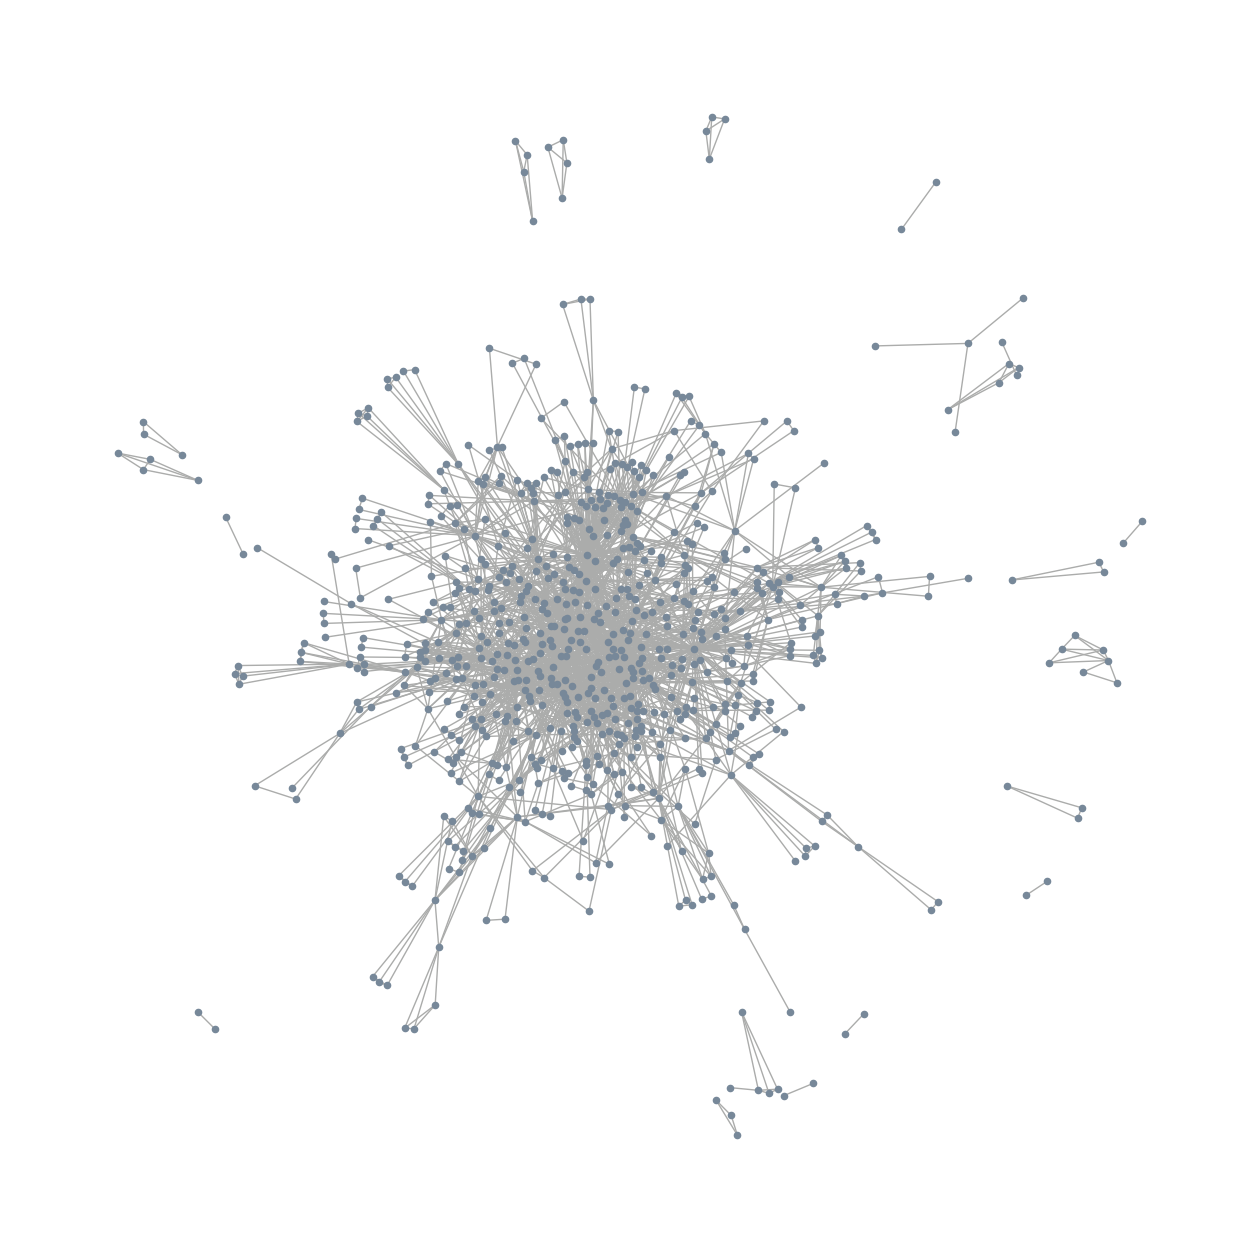

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(16, 16))

nx.draw_networkx(g, ax=ax, pos=pos, node_color='#778899',
                 edge_color='#abacab', with_labels=False, node_size=20)

ax.set_axis_off()

**1. Edge-shuffled model**

In this model, edges are randomly rearranged in the network and degree centrality is preserved. 

This model can be considered a type of *Degree-Preserving Null Model* becauses randomizes the connections in a network while keeping the degree of each node in each iteration as the same as in the original network.

In this context, this means that the total number of collaborations per artists is preserved, as well as the total number of artists (nodes) in the network and artists' gender. 

From this randomization, we remove the gendered correlation from empirical collaboration networks. Therefore, the resulting synthetic networks would show collaboration structures whith no gender preference.

To implement this null model, the random\_reference function of NetworkX is used. This function generates random graphs by swapping edges between nodes, while preserving the same degree for each node. More details can be found here: https://rdcu.be/dswrW 

In [15]:
# List with the number of iterations ~ synthetic networks
# Example of 10 synthetic networks for an easy processing
# you can do as many iterations as needed
ab = list(range(1, 11))

In [16]:
net = []

for a in ab:
    h = nx.random_reference(g) # create a random network from the empirical g

    # save network file as GEXF for further analyses
    # graph = 'netABT_'+str(a)+'.gexf'
    # nx.write_gexf(H, asd)
    
    # create dictionaries of the centralities that you need!
    # some basic centralities
    degree_dict = dict(h.degree(h.nodes()))      
    betweenness_dict=nx.betweenness_centrality(h)
    eigenvector_dict=nx.eigenvector_centrality(h, max_iter=1000)

    # add attributes to dictionary!
    nx.set_node_attributes(h, degree_dict, 'degree') 
    nx.set_node_attributes(h, betweenness_dict, 'betweenness')
    nx.set_node_attributes(h, eigenvector_dict, 'eigenvector')

    # put network metrics into data frame
    if a == '1':
        df_1 = pd.DataFrame.from_dict(dict(h.nodes(data=True)), orient='index')
        df_1['time'] = a
        net.append(df_1)
    else:
        df_2 = pd.DataFrame.from_dict(dict(h.nodes(data=True)), orient='index')
        df_2['time'] = a
        net.append(df_2)
        
# create final data frame!
total_df = pd.concat(net)

In [17]:
total_df.head(2)

,gender,degree,betweenness,eigenvector,time
Sallie Wilson,female,2,0.000033,0.014739,1
Dimitri Romanoff,male,7,0.003012,0.016378,1


In [ ]:
# total_df.to_csv('null_model1.csv', index=None, header=True)

**2. Gender-shuffled model**

In this model, the gender of artists is randomized, while holding all network properties constant. 

This means that the artists’ network position is preserved over the fixed structure of the empirical network, but their gender is randomized in each iteration. 

From this randomization, we remove preferences by artist type and display an artificial collaboration pattern without a correlation between an artist's gender and position, as well as a gendered collaboration assortativity.

To implement this null model, the gender as an attribute of the artists is randomized from the dictionary of nodes' attribute from the original network, which ensures holding the number of women and men in the synthetic networks. 

In [18]:
import random
from random import sample

In [19]:
net2 = []

for a in ab:
    dictionary = dict(zip(gender_dict, sample(list(gender_dict.values()),  
                                 len(gender_dict)))) # shuffle gender in the dictionary
    
    nx.set_node_attributes(g, dictionary, 'gender')
    
    # save network file!
    # name = 'netABT_'+str(a)+'.gexf'
    # nx.write_gexf(g, name)
    
    # create dictionaries!      
    degree_dict = dict(g.degree(g.nodes()))      
    betweenness_dict=nx.betweenness_centrality(g)
    eigenvector_dict=nx.eigenvector_centrality(g, max_iter=1000)
    
    # add attributes to dictionary!
    nx.set_node_attributes(g, degree_dict, 'degree') 
    nx.set_node_attributes(g, betweenness_dict, 'betweenness')
    nx.set_node_attributes(g, eigenvector_dict, 'eigenvector')
    
    # put network metrics into data frame
    if a == '1':
        df_1 = pd.DataFrame.from_dict(dict(g.nodes(data=True)), orient='index')
        df_1['time'] = a
        net.append(df_1)
    else:
        df_2 = pd.DataFrame.from_dict(dict(g.nodes(data=True)), orient='index')
        df_2['time'] = a
        net2.append(df_2)
        
# create final data frame!
total_df2 = pd.concat(net2)

In [20]:
total_df2.head(2)

,gender,degree,betweenness,eigenvector,time
Sallie Wilson,female,2,0.000000,0.012394,1
Dimitri Romanoff,male,7,0.000531,0.028062,1


In [ ]:
# total_df2.to_csv('null_model2.csv', index=None, header=True)

Quizz:

1. What are the differences between *shuffling* and *rewiring*? What network properties can be tested with these methods?

Further reading: A guide to null models for animal social network analysis https://doi.org/10.1111/2041-210X.12772

The models implemented above were randomized over the projection of artists from the biparitte network of ballet works and creators. 

The decision to implement a randomized model on the bipartite network or its projection depends on the specific research questions and the network characteristics.

Below there is an example of two different randomizations for collaboration networks implemented over the bipartite network. Image from: https://asistdl.onlinelibrary.wiley.com/doi/abs/10.1002/asi.24321  

![Alt text](Null_bipartite.png)

**Statistical analysis**

Statistical tests are applied to test the null hypotheses. These help compare the observed network statistics with the distribution of values obtained from the randomized networks. 

One commonly used statistical analysis is the $Z$-score test, which measures how far the mean of the empirical data is respect to the theoretical (randomized) values. This measure gives how many standard deviations the empirical data are below or above the theoretical (randomized) values. 

For instance, in the contex of network science, one can compute a $Z$-score test for a distinction between the centrality values ($C$) from the empirical network $(C_{\text{empirical}})$ and those from the null models $(C_{\text{null}})$, such as:  

\begin{equation}
Z(C) = \frac{C_{\text{empirical}} - \bar{C}_{\text{null}}}{\sigma(C_{\text{null}})}
\end{equation}

Other measures of statistical significance (e.g. t-tests) can also be implemented. 

If the observed network statistics significantly differ from what is expected under the null hypothesis, the null hypothesis can be rejected. This rejection suggests that the observed network features are not likely to have occurred by random chance alone.

**Exercise:** 
    
1. Compute the z-score for the centralities for each model. What conclusions can you draw from the z-score results? What other statistical comparisons would you test? 

2. What other models could be implemented over this type of collaboration network? Should a randomized model on the bipartite network be considered?

3. Imagine you have information of the weight and direction of the edges, which can indicate the type of interactions the artists have among them. How would you randomize the network to test collaboration preferences by gender? 

4. Lastly, can null models explain network effects? Explain. 